In [19]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import matplotlib.pyplot as plt 
import dython.nominal as dy
import warnings

warnings.filterwarnings('ignore')

Collect the Rookie Data for Current Rookies

In [4]:
rookies2023 = nfl.import_combine_data([2023])
rookies2023.head()

,season,draft_year,draft_team,draft_round,draft_ovr,pfr_id,cfb_id,player_name,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle
7680,2023,2023.0,New York Jets,5.0,143.0,AbanIs00,israel-abanikanda-1,Israel Abanikanda,RB,Pittsburgh,5-10,216.0,NaN,NaN,NaN,NaN,NaN,NaN
7681,2023,2023.0,Jacksonville Jaguars,5.0,136.0,AbduYa00,yasir-abdullah-1,Yasir Abdullah,LB,Louisville,6-1,237.0,4.47,NaN,36.5,129.0,NaN,NaN
7682,2023,2023.0,Miami Dolphins,3.0,84.0,AchaDe00,devon-achane-1,Devon Achane,RB,Texas A&M,5-9,188.0,4.32,NaN,33.0,NaN,NaN,NaN
7683,2023,2023.0,Minnesota Vikings,1.0,23.0,AddiJo00,jordan-addison-1,Jordan Addison,WR,USC,5-11,173.0,4.49,NaN,34.0,122.0,NaN,NaN
7684,2023,2023.0,Indianapolis Colts,4.0,110.0,AdebAd00,adetomiwa-adebawore-1,Adetomiwa Adebawore,DE,Northwestern,6-2,282.0,4.49,27.0,37.5,125.0,NaN,NaN


Collect the Rookie Data for Rookies from 2000-2022

In [5]:
rookies00to22 = nfl.import_combine_data(range(2000,2023))
rookies00to22.head()

,season,draft_year,draft_team,draft_round,draft_ovr,pfr_id,cfb_id,player_name,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle
0,2000,2000.0,New York Jets,1.0,13.0,AbraJo00,None,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,2000,2000.0,Seattle Seahawks,1.0,19.0,AlexSh00,shaun-alexander-1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,2000,2000.0,Kansas City Chiefs,6.0,188.0,AlfoDa20,None,Darnell Alford,OT,Boston Col.,6-4,334.0,5.56,23.0,25.0,94.0,8.48,4.98
3,2000,NaN,None,NaN,NaN,None,None,Kyle Allamon,TE,Texas Tech,6-2,253.0,4.97,NaN,29.0,104.0,7.29,4.49
4,2000,2000.0,Carolina Panthers,1.0,23.0,AndeRa21,None,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,NaN,34.0,123.0,7.18,4.15


Function to convert heights to inches

In [13]:
def parse_ht(ht):
    # format: 6-1
    ht_ = ht.split("-")
    ft_ = float(ht_[0])
    in_ = float(ht_[1])
    return (12*ft_) + in_

Scrape pro football reference for all fantasy data from 2000-2022

In [ ]:
url = 'https://www.pro-football-reference.com'
maxp = 515

df = []


for year in range(2000, 2023):
    # grab fantasy players
    r = requests.get(url + '/years/' + str(year) + '/fantasy.htm')
    soup = BeautifulSoup(r.content, 'html.parser')
    parsed_table = soup.find_all('table')[0]  

    # first 2 rows are col headers
    for i,row in enumerate(parsed_table.find_all('tr')[2:]):
        if i % 10 == 0: 
            print(i, end=' ')
        if i >= maxp: 
            print('\nComplete.')
            break

        time.sleep(5)
        try:
            dat = row.find('td', attrs={'data-stat': 'player'})
            name = dat.a.get_text()
            pfr_id = dat.get('data-append-csv')
            stub = dat.a.get('href')
            stub = stub[:-4] + '/fantasy/' + str(year)
            pos = row.find('td', attrs={'data-stat': 'fantasy_pos'}).get_text()

            # grab this players stats
            tdf = pd.read_html(url + stub)[0]

            # get rid of MultiIndex, just keep last row
            tdf.columns = tdf.columns.get_level_values(-1)

            # drop all intermediate stats
            tdf = tdf.iloc[:,[-2]]
            
            # drop "Total" row
            tdf = tdf[:-1]
            
            # add other info
            tdf['Name'] = name
            tdf['PFR_ID'] = pfr_id
            tdf['Position'] = pos
            tdf['Season'] = year

            df.append(tdf)
        except:
            pass

df = pd.concat(df)
df.head()
df.to_csv('fantasy00to22.csv')

Prepare data for use

In [8]:
fantasy00to22 = pd.read_csv('Data/fantasy00to22.csv', usecols=["DKPt", "Name", "PFR_ID", "Position", "Season"])
fantasy00to22.rename(columns = {'DKPt': 'PPR_Fantasy_Points', "PFR_ID": 'pfr_id'}, inplace=True)
fantasy00to22.head()

,PPR_Fantasy_Points,Name,pfr_id,Position,Season
0,36.8,Marshall Faulk,FaulMa00,RB,2000
1,30.3,Marshall Faulk,FaulMa00,RB,2000
2,47.9,Marshall Faulk,FaulMa00,RB,2000
3,12.6,Marshall Faulk,FaulMa00,RB,2000
4,38.1,Marshall Faulk,FaulMa00,RB,2000


Use average of median and average to be metric of player's season

In [9]:
fantasySeasonData00to22 = fantasy00to22.groupby(["Name", "pfr_id", "Position", "Season"], as_index=False)["PPR_Fantasy_Points"].mean()
fantasySeasonData00to22.rename(columns = {'PPR_Fantasy_Points': 'Avg_PPR_Fantasy_Points'}, inplace=True)
fantasySeasonData00to22['Med_PPR_Fantasy_Points'] = fantasy00to22.groupby(["Name", "pfr_id", "Position", "Season"], as_index=False)["PPR_Fantasy_Points"].median()["PPR_Fantasy_Points"]
fantasySeasonData00to22["MedAvg_PPR_Fantasy_Points"] = (fantasySeasonData00to22["Avg_PPR_Fantasy_Points"] + fantasySeasonData00to22["Med_PPR_Fantasy_Points"]) / 2
fantasySeasonData00to22.head()

,Name,pfr_id,Position,Season,Avg_PPR_Fantasy_Points,Med_PPR_Fantasy_Points,MedAvg_PPR_Fantasy_Points
0,A.J. Brown,BrowAJ00,WR,2019,14.506250,12.15,13.328125
1,A.J. Brown,BrowAJ00,WR,2020,18.607143,18.70,18.653571
2,A.J. Brown,BrowAJ00,WR,2021,14.607692,9.80,12.203846
3,A.J. Brown,BrowAJ00,WR,2022,18.623529,17.00,17.811765
4,A.J. Derby,DerbA.00,TE,2016,6.200000,7.50,6.850000


Take top 5 seasons and average them

In [10]:
fantasySeasonData00to22Top5 = fantasySeasonData00to22.groupby(["Name", "pfr_id", "Position"], as_index=False)['MedAvg_PPR_Fantasy_Points'].apply(lambda grp: grp.nlargest(5).mean())
fantasySeasonData00to22Top5.head()

,Name,pfr_id,Position,MedAvg_PPR_Fantasy_Points
0,A.J. Brown,BrowAJ00,WR,15.499327
1,A.J. Derby,DerbA.00,TE,4.773333
2,A.J. Feeley,FeelA.00,QB,11.793030
3,A.J. Green,GreeA.00,WR,19.505631
4,A.J. Jenkins,JenkA.00,WR,3.346667


Merge fantasy data with rookie data

In [11]:
fullData00to22 = rookies00to22.merge(fantasySeasonData00to22Top5, on="pfr_id")
fullData00to22 = fullData00to22.drop(columns="Position")
fullData00to22.columns

Index(['season', 'draft_year', 'draft_team', 'draft_round', 'draft_ovr',
       'pfr_id', 'cfb_id', 'player_name', 'pos', 'school', 'ht', 'wt', 'forty',
       'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'Name',
       'MedAvg_PPR_Fantasy_Points'],
      dtype='object')

Apply height function

In [14]:
fullData00to22["ht"] = fullData00to22["ht"].apply(lambda x: parse_ht(x) if x else x)
fullData00to22.head()

,season,draft_year,draft_team,draft_round,draft_ovr,pfr_id,cfb_id,player_name,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle,Name,MedAvg_PPR_Fantasy_Points
0,2000,2000.0,Seattle Seahawks,1.0,19.0,AlexSh00,shaun-alexander-1,Shaun Alexander,RB,Alabama,72.0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,Shaun Alexander,21.898750
1,2000,2000.0,New York Jets,1.0,27.0,BechAn00,anthony-becht-1,Anthony Becht,TE,West Virginia,78.0,270.0,4.78,NaN,33.5,123.0,6.94,4.08,Anthony Becht,5.231302
2,2000,2000.0,New England Patriots,6.0,199.0,BradTo00,tom-brady-1,Tom Brady,QB,Michigan,76.0,211.0,5.28,NaN,24.5,99.0,7.20,4.38,Tom Brady,25.114301
3,2000,NaN,None,NaN,NaN,BrowTr01,None,Travis Brown,QB,Northern Arizona,75.0,218.0,5.01,NaN,29.0,101.0,7.54,4.87,Travis Brown,6.975000
4,2000,2000.0,New Orleans Saints,6.0,168.0,BulgMa00,marc-bulger-1,Marc Bulger,QB,West Virginia,74.0,208.0,4.97,NaN,NaN,100.0,7.46,4.34,Marc Bulger,18.621315


See how draft/combine data is correlated for WR

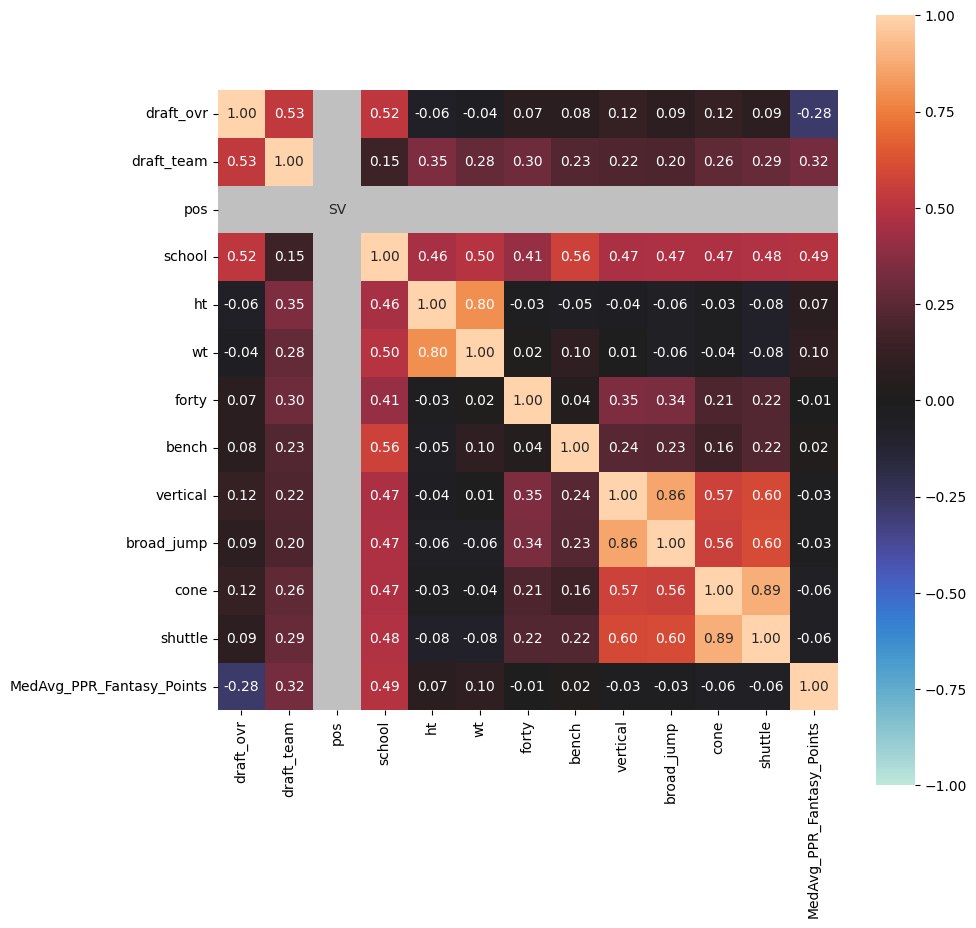

,draft_ovr,draft_team,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle,MedAvg_PPR_Fantasy_Points
draft_ovr,1.00,0.53,0.00,0.52,-0.06,-0.04,0.07,0.08,0.12,0.09,0.12,0.09,-0.28
draft_team,0.53,1.00,0.00,0.15,0.35,0.28,0.30,0.23,0.22,0.20,0.26,0.29,0.32
pos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
school,0.52,0.15,0.00,1.00,0.46,0.50,0.41,0.56,0.47,0.47,0.47,0.48,0.49
ht,-0.06,0.35,0.00,0.46,1.00,0.80,-0.03,-0.05,-0.04,-0.06,-0.03,-0.08,0.07
wt,-0.04,0.28,0.00,0.50,0.80,1.00,0.02,0.10,0.01,-0.06,-0.04,-0.08,0.10
forty,0.07,0.30,0.00,0.41,-0.03,0.02,1.00,0.04,0.35,0.34,0.21,0.22,-0.01
bench,0.08,0.23,0.00,0.56,-0.05,0.10,0.04,1.00,0.24,0.23,0.16,0.22,0.02
vertical,0.12,0.22,0.00,0.47,-0.04,0.01,0.35,0.24,1.00,0.86,0.57,0.60,-0.03
broad_jump,0.09,0.20,0.00,0.47,-0.06,-0.06,0.34,0.23,0.86,1.00,0.56,0.60,-0.03


In [20]:
WRDat = fullData00to22[['draft_ovr', 'draft_team', 'pos', 'school', 'ht', 'wt', 'forty', 'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'MedAvg_PPR_Fantasy_Points']]
WRDat = WRDat[WRDat['pos'] == 'WR']
complete_correlation = dy.associations(WRDat, filename= 'complete_correlation.png', figsize=(10,10))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

See how draft/combine data is correlated for RB

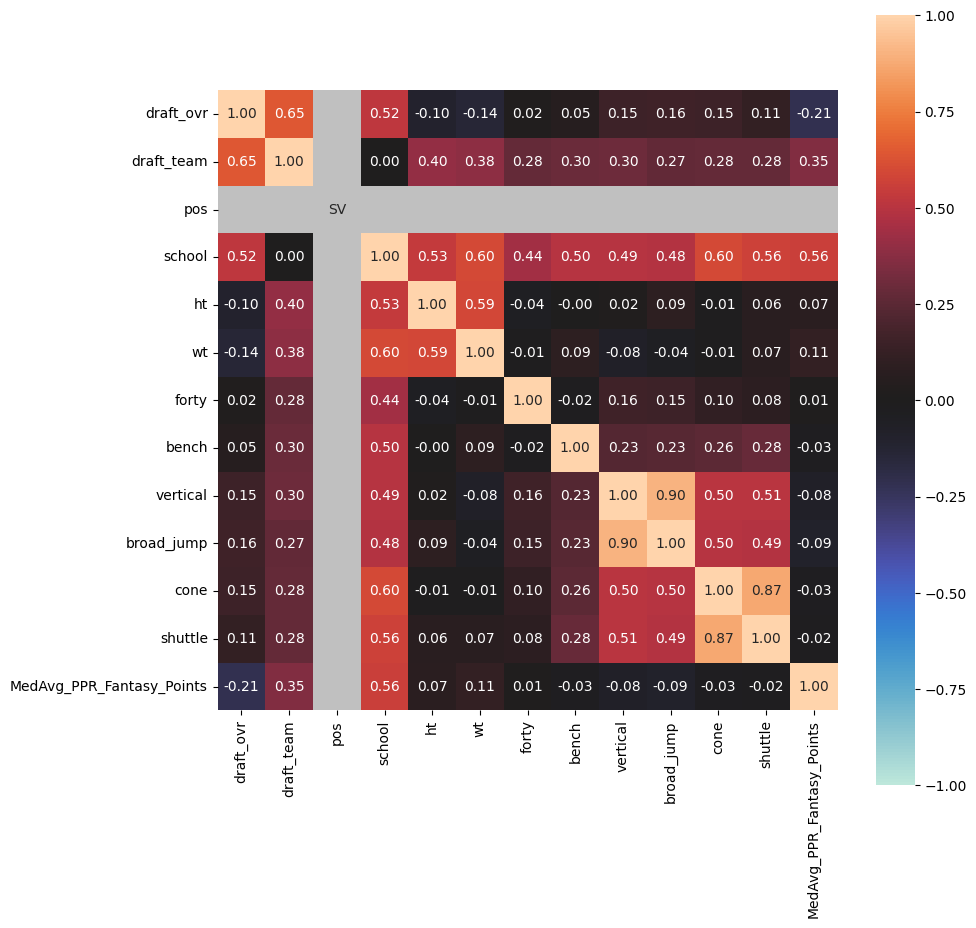

,draft_ovr,draft_team,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle,MedAvg_PPR_Fantasy_Points
draft_ovr,1.00,0.65,0.00,0.52,-0.10,-0.14,0.02,0.05,0.15,0.16,0.15,0.11,-0.21
draft_team,0.65,1.00,0.00,0.00,0.40,0.38,0.28,0.30,0.30,0.27,0.28,0.28,0.35
pos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
school,0.52,0.00,0.00,1.00,0.53,0.60,0.44,0.50,0.49,0.48,0.60,0.56,0.56
ht,-0.10,0.40,0.00,0.53,1.00,0.59,-0.04,-0.00,0.02,0.09,-0.01,0.06,0.07
wt,-0.14,0.38,0.00,0.60,0.59,1.00,-0.01,0.09,-0.08,-0.04,-0.01,0.07,0.11
forty,0.02,0.28,0.00,0.44,-0.04,-0.01,1.00,-0.02,0.16,0.15,0.10,0.08,0.01
bench,0.05,0.30,0.00,0.50,-0.00,0.09,-0.02,1.00,0.23,0.23,0.26,0.28,-0.03
vertical,0.15,0.30,0.00,0.49,0.02,-0.08,0.16,0.23,1.00,0.90,0.50,0.51,-0.08
broad_jump,0.16,0.27,0.00,0.48,0.09,-0.04,0.15,0.23,0.90,1.00,0.50,0.49,-0.09


In [21]:
RBDat = fullData00to22[['draft_ovr', 'draft_team', 'pos', 'school', 'ht', 'wt', 'forty', 'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'MedAvg_PPR_Fantasy_Points']]
RBDat = RBDat[RBDat['pos'] == 'RB']
complete_correlation = dy.associations(RBDat, filename= 'complete_correlation.png', figsize=(10,10))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

See how draft/combine data is correlated for QB

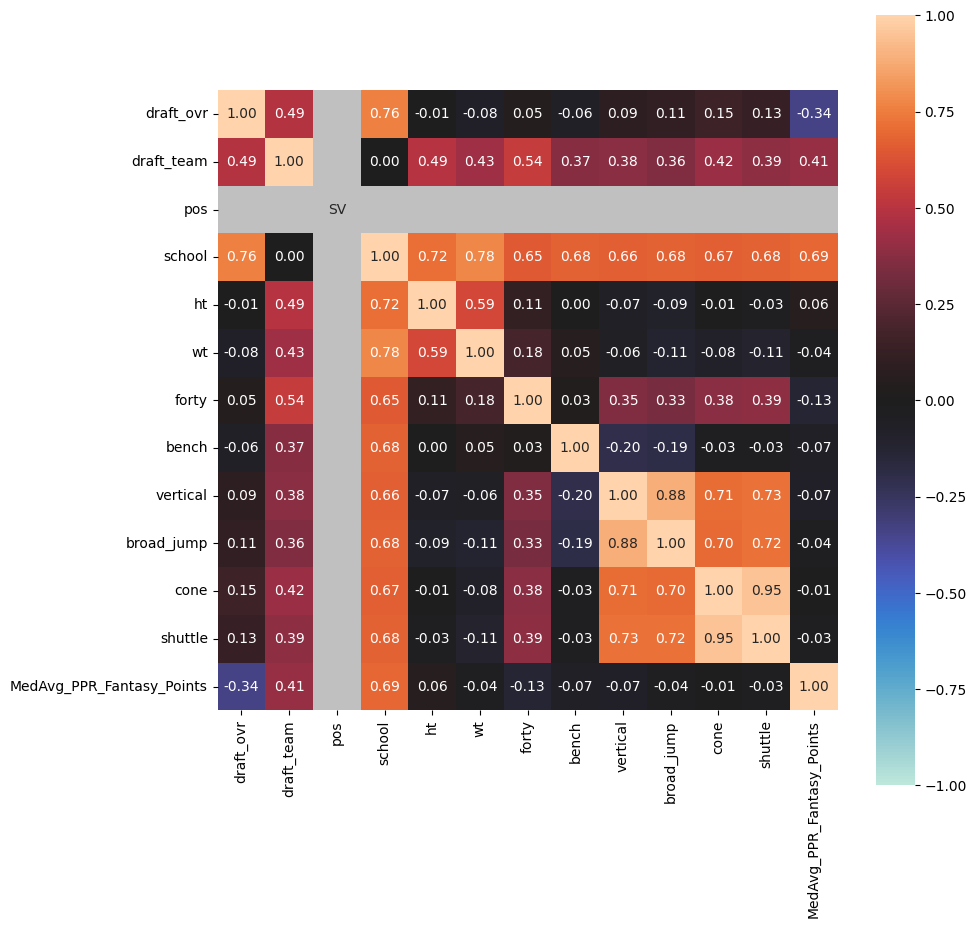

,draft_ovr,draft_team,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle,MedAvg_PPR_Fantasy_Points
draft_ovr,1.00,0.49,0.00,0.76,-0.01,-0.08,0.05,-0.06,0.09,0.11,0.15,0.13,-0.34
draft_team,0.49,1.00,0.00,0.00,0.49,0.43,0.54,0.37,0.38,0.36,0.42,0.39,0.41
pos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
school,0.76,0.00,0.00,1.00,0.72,0.78,0.65,0.68,0.66,0.68,0.67,0.68,0.69
ht,-0.01,0.49,0.00,0.72,1.00,0.59,0.11,0.00,-0.07,-0.09,-0.01,-0.03,0.06
wt,-0.08,0.43,0.00,0.78,0.59,1.00,0.18,0.05,-0.06,-0.11,-0.08,-0.11,-0.04
forty,0.05,0.54,0.00,0.65,0.11,0.18,1.00,0.03,0.35,0.33,0.38,0.39,-0.13
bench,-0.06,0.37,0.00,0.68,0.00,0.05,0.03,1.00,-0.20,-0.19,-0.03,-0.03,-0.07
vertical,0.09,0.38,0.00,0.66,-0.07,-0.06,0.35,-0.20,1.00,0.88,0.71,0.73,-0.07
broad_jump,0.11,0.36,0.00,0.68,-0.09,-0.11,0.33,-0.19,0.88,1.00,0.70,0.72,-0.04


In [22]:
QBDat = fullData00to22[['draft_ovr', 'draft_team', 'pos', 'school', 'ht', 'wt', 'forty', 'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'MedAvg_PPR_Fantasy_Points']]
QBDat = QBDat[QBDat['pos'] == 'QB']
complete_correlation = dy.associations(QBDat, filename= 'complete_correlation.png', figsize=(10,10))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

See how draft/combine data is correlated for TE

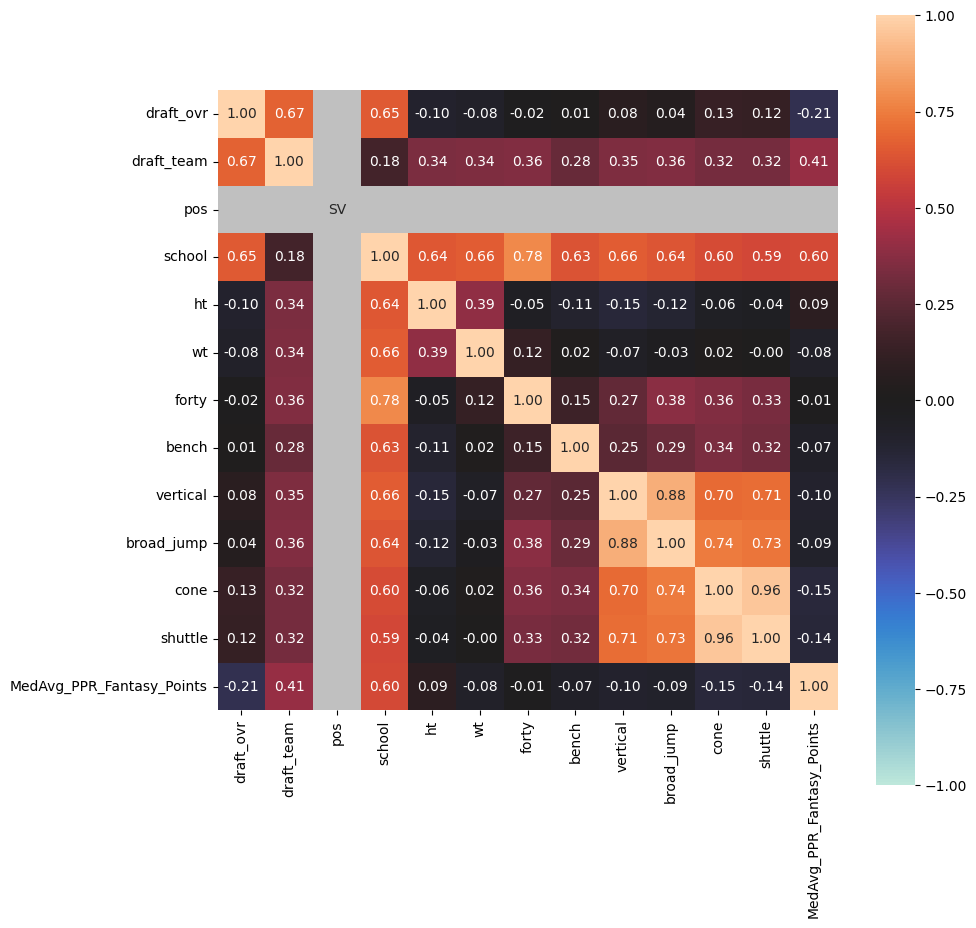

,draft_ovr,draft_team,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle,MedAvg_PPR_Fantasy_Points
draft_ovr,1.00,0.67,0.00,0.65,-0.10,-0.08,-0.02,0.01,0.08,0.04,0.13,0.12,-0.21
draft_team,0.67,1.00,0.00,0.18,0.34,0.34,0.36,0.28,0.35,0.36,0.32,0.32,0.41
pos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
school,0.65,0.18,0.00,1.00,0.64,0.66,0.78,0.63,0.66,0.64,0.60,0.59,0.60
ht,-0.10,0.34,0.00,0.64,1.00,0.39,-0.05,-0.11,-0.15,-0.12,-0.06,-0.04,0.09
wt,-0.08,0.34,0.00,0.66,0.39,1.00,0.12,0.02,-0.07,-0.03,0.02,-0.00,-0.08
forty,-0.02,0.36,0.00,0.78,-0.05,0.12,1.00,0.15,0.27,0.38,0.36,0.33,-0.01
bench,0.01,0.28,0.00,0.63,-0.11,0.02,0.15,1.00,0.25,0.29,0.34,0.32,-0.07
vertical,0.08,0.35,0.00,0.66,-0.15,-0.07,0.27,0.25,1.00,0.88,0.70,0.71,-0.10
broad_jump,0.04,0.36,0.00,0.64,-0.12,-0.03,0.38,0.29,0.88,1.00,0.74,0.73,-0.09


In [23]:
TEDat = fullData00to22[['draft_ovr', 'draft_team', 'pos', 'school', 'ht', 'wt', 'forty', 'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'MedAvg_PPR_Fantasy_Points']]
TEDat = TEDat[TEDat['pos'] == 'TE']
complete_correlation = dy.associations(TEDat, filename= 'complete_correlation.png', figsize=(10,10))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

Prep CFB IDs for scraping sport reference

In [3]:
cfb_ids = nfl.import_combine_data(range(2000,2024))[["cfb_id", "pos", "player_name"]]
cfb_ids = cfb_ids.dropna(subset=['cfb_id'])

Filter out relevant positions

In [44]:
cfb_ids = cfb_ids[(cfb_ids["pos"] == "QB") | (cfb_ids["pos"] == "RB") | (cfb_ids["pos"] == "WR") | (cfb_ids["pos"] == "TE")]
cfb_ids.head()

,cfb_id,pos,player_name
1,shaun-alexander-1,RB,Shaun Alexander
18,anthony-becht-1,TE,Anthony Becht
27,tom-brady-1,QB,Tom Brady
36,marc-bulger-1,QB,Marc Bulger
39,plaxico-burress-1,WR,Plaxico Burress


In [4]:
cfb_qbs = cfb_ids[cfb_ids["pos"] == "QB"]
cfb_rbs = cfb_ids[cfb_ids["pos"] == "RB"]
cfb_wrs = cfb_ids[cfb_ids["pos"] == "WR"]
cfb_tes = cfb_ids[cfb_ids["pos"] == "TE"]

Scrape for data

In [ ]:
url = 'https://www.sports-reference.com/cfb/players/'
print(len(cfb_tes))

df = []

for index, row in cfb_tes.iterrows():
    if index % 10 == 0: print(index, end=' ')
    
    time.sleep(5)
    cfb_id, pos, name = row['cfb_id'], row['pos'], row['player_name']
    try:
        tdf = pd.read_html(url + cfb_id + '/gamelog/')[0]
        tdf.columns = tdf.columns.get_level_values(-1)
        tdf = tdf.iloc[:,[1, 3, 7, 8, 9, 10]]
        tdf.columns =  ['Year', 'School', 'Rec', 'Rec_Yds', 'Rec_Avg', 'Rec_TD']
        tdf['Year'] = pd.to_numeric(tdf['Year'], errors='coerce')
        tdf = tdf.dropna(subset=['Year'])
        tdf['pfr_id'] = cfb_id
        tdf['Position'] = pos
        tdf['Name'] = name

        df.append(tdf)
    except:
        pass

df = pd.concat(df)
df.head()
df.to_csv('collegeTE_stats.csv')   

Get WR Data

In [27]:
collegeWRStats = pd.read_csv('Data/collegeWR_stats.csv')
collegeWRStats.rename(columns = {'pfr_id': 'cfb_id'}, inplace=True)
collegeWRStats.head()

,Unnamed: 0,Year,School,Rec,Rec_Yds,Rec_Avg,Rec_TD,Rush_Att,Rush_Yds,Rush_Avg,Rush_TD,cfb_id,Position,Name
0,0,2000.0,Tulsa,5,107,21.4,1.0,4.0,67.0,16.8,0.0,corey-brown-1,WR,Corey Brown
1,1,2000.0,Tulsa,9,98,10.9,1.0,1.0,20.0,20.0,0.0,corey-brown-1,WR,Corey Brown
2,2,2000.0,Tulsa,2,11,5.5,0.0,0.0,0.0,NaN,0.0,corey-brown-1,WR,Corey Brown
3,3,2000.0,Tulsa,4,29,7.3,1.0,3.0,60.0,20.0,0.0,corey-brown-1,WR,Corey Brown
4,4,2000.0,Tulsa,5,65,13.0,0.0,0.0,0.0,NaN,0.0,corey-brown-1,WR,Corey Brown


Combine WR Draft/Combine data with college stats

In [28]:
fullWRData00to22 = fullData00to22[fullData00to22["pos"] == "WR"]
fullWRData00to22 = fullData00to22.merge(collegeWRStats, on='cfb_id')
fullWRData00to22.columns

Index(['season', 'draft_year', 'draft_team', 'draft_round', 'draft_ovr',
       'pfr_id', 'cfb_id', 'player_name', 'pos', 'school', 'ht', 'wt', 'forty',
       'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'Name_x',
       'MedAvg_PPR_Fantasy_Points', 'Unnamed: 0', 'Year', 'School', 'Rec',
       'Rec_Yds', 'Rec_Avg', 'Rec_TD', 'Rush_Att', 'Rush_Yds', 'Rush_Avg',
       'Rush_TD', 'Position', 'Name_y'],
      dtype='object')

See correlations with new data

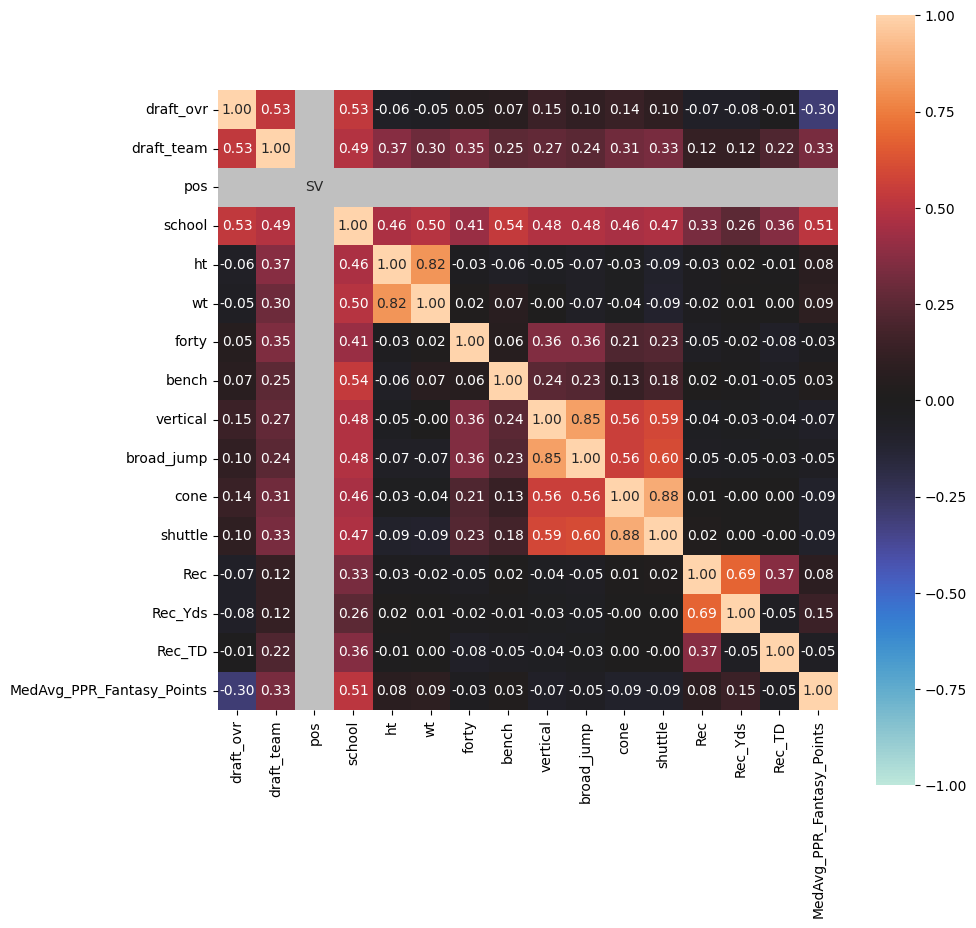

,draft_ovr,draft_team,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle,Rec,Rec_Yds,Rec_TD,MedAvg_PPR_Fantasy_Points
draft_ovr,1.00,0.53,0.00,0.53,-0.06,-0.05,0.05,0.07,0.15,0.10,0.14,0.10,-0.07,-0.08,-0.01,-0.30
draft_team,0.53,1.00,0.00,0.49,0.37,0.30,0.35,0.25,0.27,0.24,0.31,0.33,0.12,0.12,0.22,0.33
pos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
school,0.53,0.49,0.00,1.00,0.46,0.50,0.41,0.54,0.48,0.48,0.46,0.47,0.33,0.26,0.36,0.51
ht,-0.06,0.37,0.00,0.46,1.00,0.82,-0.03,-0.06,-0.05,-0.07,-0.03,-0.09,-0.03,0.02,-0.01,0.08
wt,-0.05,0.30,0.00,0.50,0.82,1.00,0.02,0.07,-0.00,-0.07,-0.04,-0.09,-0.02,0.01,0.00,0.09
forty,0.05,0.35,0.00,0.41,-0.03,0.02,1.00,0.06,0.36,0.36,0.21,0.23,-0.05,-0.02,-0.08,-0.03
bench,0.07,0.25,0.00,0.54,-0.06,0.07,0.06,1.00,0.24,0.23,0.13,0.18,0.02,-0.01,-0.05,0.03
vertical,0.15,0.27,0.00,0.48,-0.05,-0.00,0.36,0.24,1.00,0.85,0.56,0.59,-0.04,-0.03,-0.04,-0.07
broad_jump,0.10,0.24,0.00,0.48,-0.07,-0.07,0.36,0.23,0.85,1.00,0.56,0.60,-0.05,-0.05,-0.03,-0.05


In [29]:
WRDat = fullWRData00to22[['draft_ovr', 'draft_team', 'pos', 'school', 'ht', 'wt', 'forty', 'bench', 'vertical', 'broad_jump', 'cone', 'shuttle', 'Rec', 'Rec_Yds', 'Rec_TD', 'MedAvg_PPR_Fantasy_Points']]
WRDat = WRDat[WRDat['pos'] == 'WR']
complete_correlation = dy.associations(WRDat, filename= 'complete_correlation.png', figsize=(10,10))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)